# Análise Preditiva - Custos Médicos Plano de Saúde
O objetivo desta análise é gerar alguns modelos utilizando técnicas diferentes, além de alguns pré-processamentos, para estimar o valor que será cobrado pelo plano de saúde a um determinado cliente.
Como base de estudo será utilizado a base 'insurance' disponível [aqui](https://www.kaggle.com/datasets/willianoliveiragibin/healthcare-insurance).

In [1]:
import pandas as pd
dataset = pd.read_csv('insurance.csv')
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Como primeira etapa é preciso conhecer os dados:
- Descobrir tamanho dos dados;
- Identificar os tipos de dados para analisar os tratamentos necessários;

In [4]:
dataset.shape

(1338, 7)

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
dataset.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


A primeira análise mostra que não existem dados faltantes e existem alguns items com informação categórica. Alguns parecem ter conteúdo binário, facilitando a conversão, mas outros vão precisar de uma estratégia de categorização one-hot pra facilitar o funcionamento de algoritmos de machine learning. 

## Análise Exploratória
A seguir, uma análise exploratória pra saber se os dados são representativos e válidos.

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

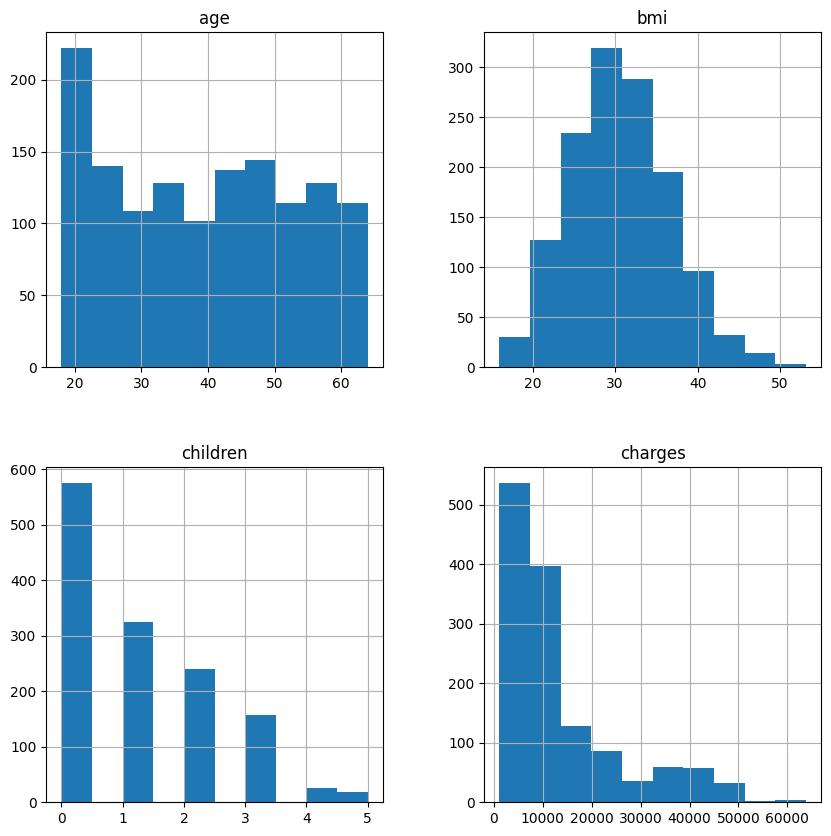

In [2]:
dataset.hist(figsize=(10,10))

Inicialmente espera-se que fumantes tenham maior probabilidade de terem mais encargos com seguro saúde. Para validar a teoria no gráfico abaixo primeiro vemos que a distribuição entre fumantes e não fumantes parecem ser equivalentes e uniformes. Existem fumantes de diversas idades, assim como não fumantes. O mesmo se observa para o gênero.

c:\Projects\ai4dev1\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 11.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


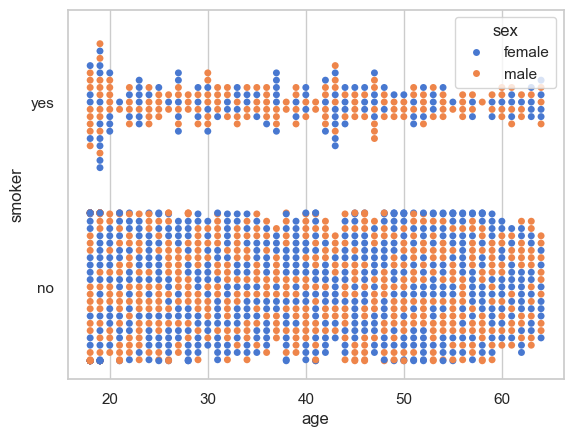

In [3]:
import seaborn as sb
sb.set_theme(style='whitegrid', palette="muted")

smoker_age_analysis = sb.swarmplot(data=dataset, x="age", y="smoker", hue="sex")

Abaixo, iremos usar o boxplot e o gráfico violino para comparar os valores de encardos entre fumantes e não fumantes.

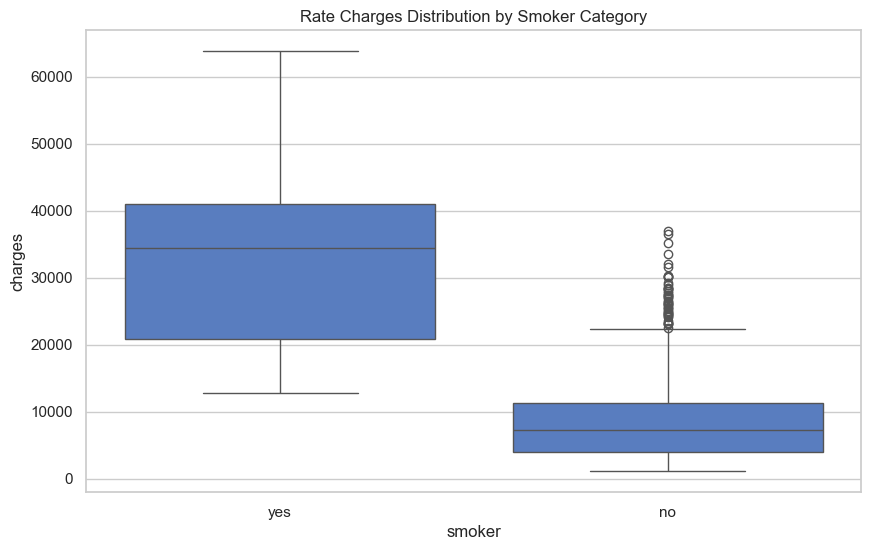

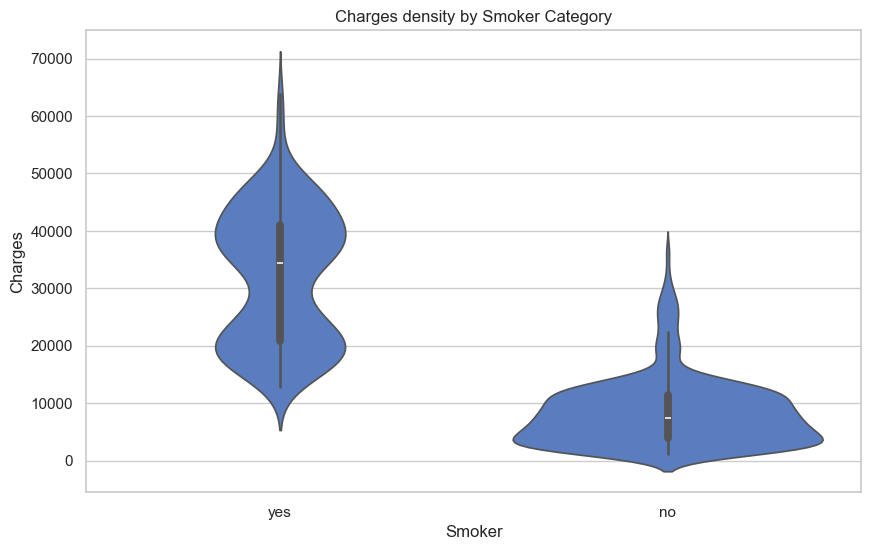

In [20]:
import matplotlib.pyplot as plt

def boxplot_charges_distribution(xlabel, title):
    ylabel = "charges"
    plt.figure(figsize=(10, 6))
    sb.boxplot(x=xlabel, y=ylabel, data=dataset)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

boxplot_charges_distribution(xlabel="smoker", title="Rate Charges Distribution by Smoker Category")

plt.figure(figsize=(10, 6))
sb.violinplot(x="smoker", y="charges", data=dataset)
plt.title("Charges density by Smoker Category")
plt.xlabel("Smoker")
plt.ylabel("Charges")
plt.show()

Os gráficos anteriores mostram que quase sempre fumantes possuem maiores encargos financeiros. A média deixa claro a discrepância. Inclusive os maiores valores de custo com plano de saúde são tidos como outliers.

Vamos a seguir verificar se existe alguma relação dos custos comparando com gênero, número de filhos e região.

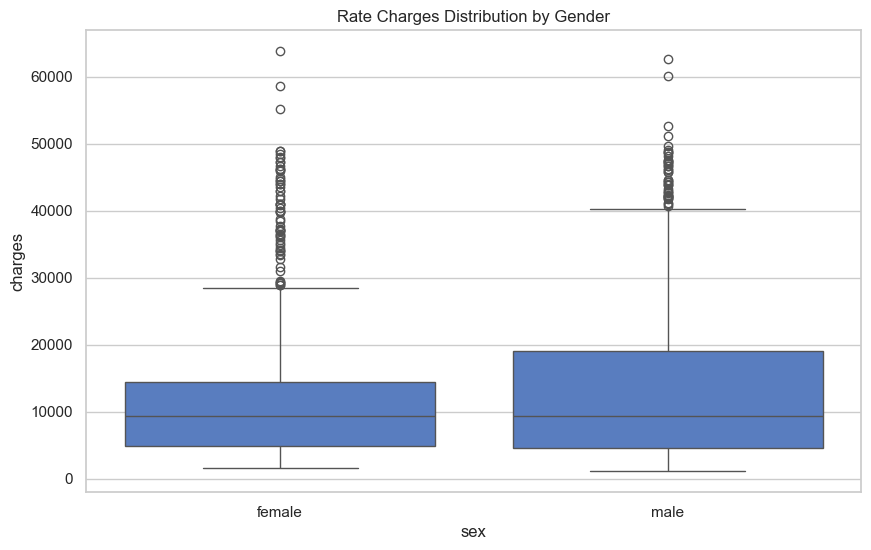

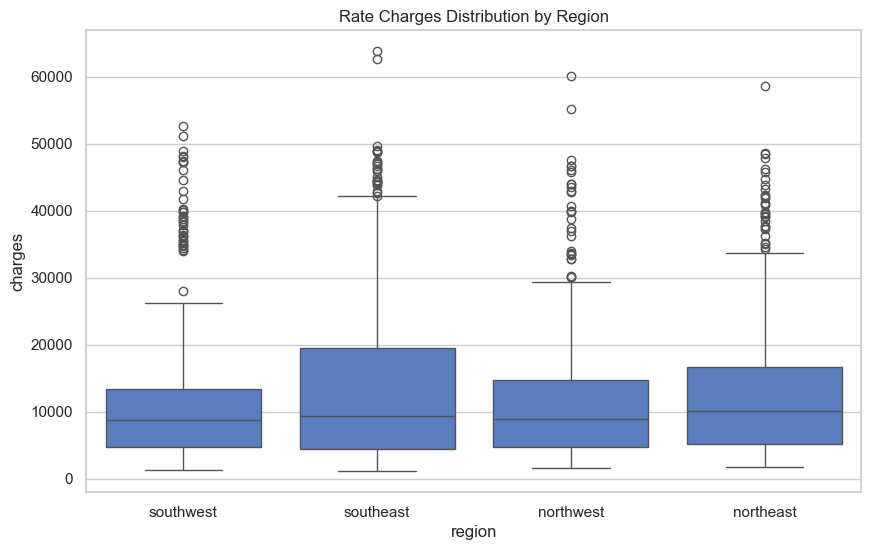

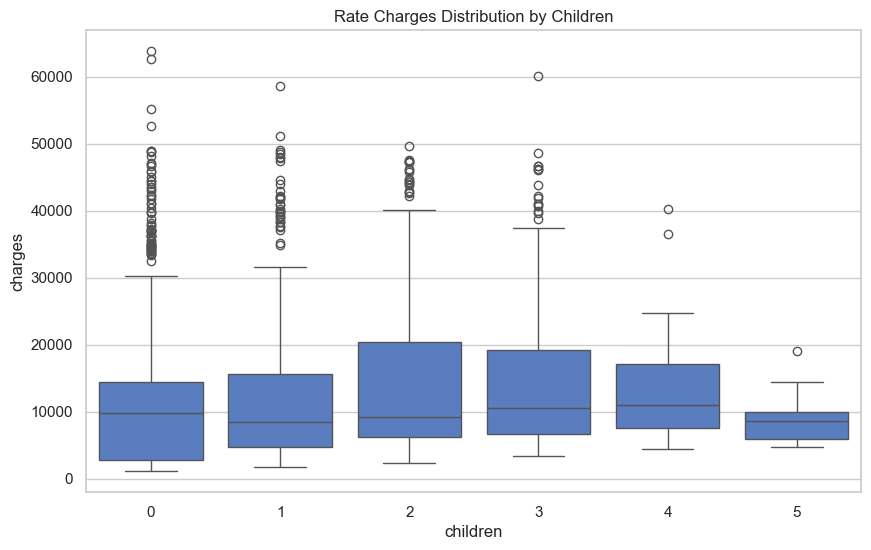

In [19]:
boxplot_charges_distribution(xlabel="sex", title="Rate Charges Distribution by Gender")
boxplot_charges_distribution(xlabel="region", title="Rate Charges Distribution by Region")
boxplot_charges_distribution(xlabel="children", title="Rate Charges Distribution by Children")

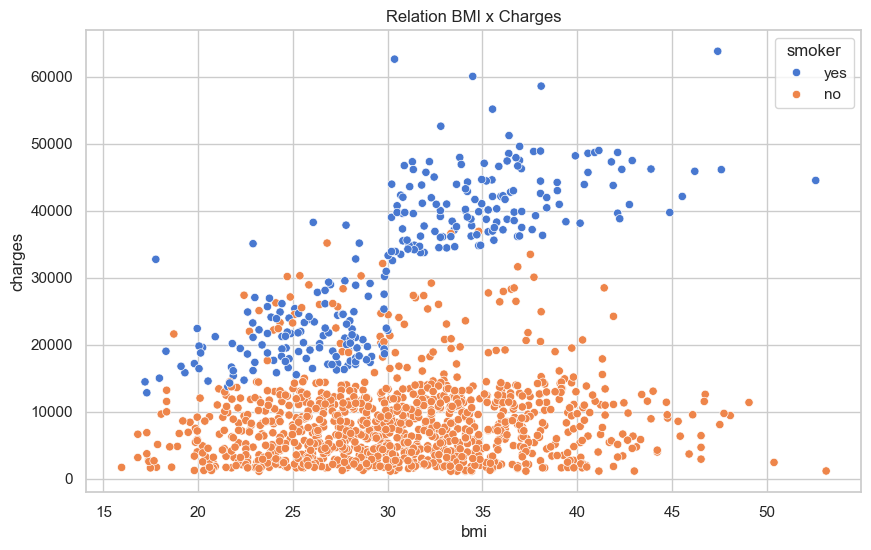

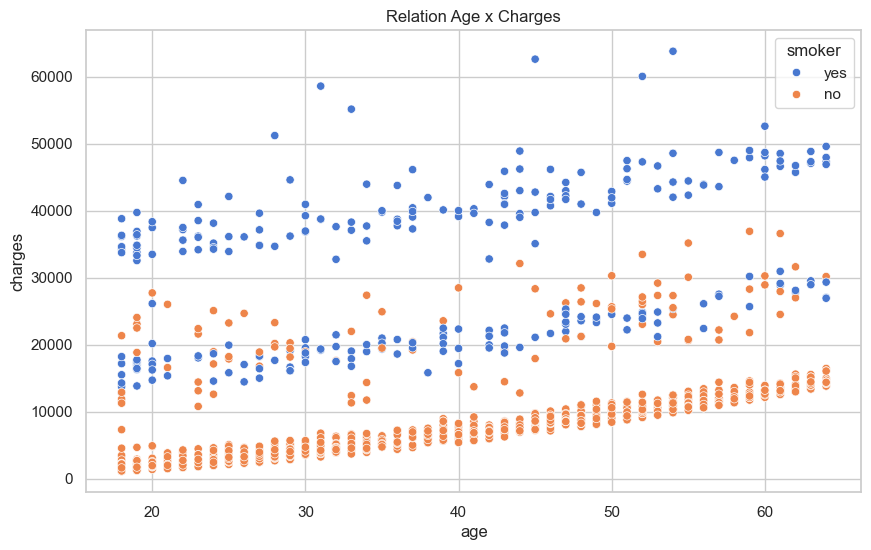

In [29]:
def scatter_charger_distribution(xlabel, title):
    ylabel = "charges"
    plt.figure(figsize=(10, 6))
    sb.scatterplot(x=xlabel, y=ylabel, data=dataset, hue="smoker")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

scatter_charger_distribution(xlabel="bmi", title="Relation BMI x Charges")
scatter_charger_distribution(xlabel="age", title="Relation Age x Charges")

As análises para gênero, região e número de filhos na apresentou dados relevantes que indicassem uma correlação assim como a categoria de fumantes. Por outro lado o aumento do IMC mostrou existir uma relação ao custo com o seguro saúde quando o individúo é fumante. Pessoas com IMC acima de 30 (pessoas com algum nível de obesidade) e fumante possuem grande indicativo de aumento no custos com a saúde. Por fim, e como esperado os custos com o plano de saúde cresce conforme a idade aumenta.

## Tratamento dos Dados
Agora os dados precisam ser categorizados de forma númerica para serem considerados no modelo.

In [32]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

dataset_coded = dataset.copy()
dataset_coded['sex'] = label_encoder.fit_transform(dataset_coded['sex'])
dataset_coded['smoker'] = label_encoder.fit_transform(dataset_coded['smoker'])

dummy_region = pd.get_dummies(dataset_coded['region'], prefix='dummy')
dataset_coded = pd.concat([dataset_coded, dummy_region], axis=1)
dataset_coded.drop("region", axis=1, inplace=True)

dataset_coded.head()

,age,sex,bmi,children,smoker,charges,dummy_northeast,dummy_northwest,dummy_southeast,dummy_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


Tentando verificar correção entre os dados com o custos do plano de saúde.

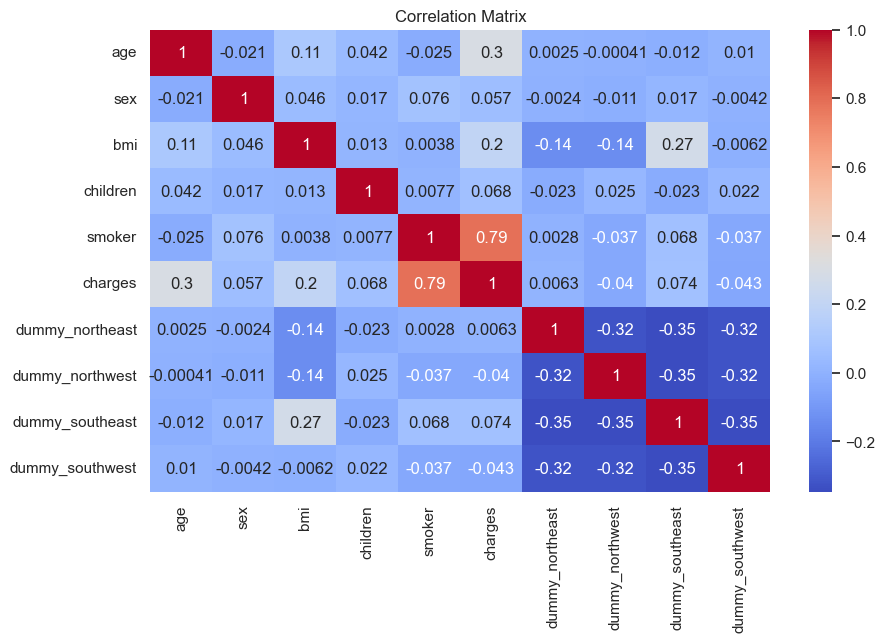

In [34]:
corr_matrix = dataset_coded.corr()
plt.figure(figsize=(10, 6))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

A matriz de correção mostra de forma evidente o que tinhamos explorado antes, ser fumante está relacionado aos custos com seguro saúde. Perceba que a idade e o IMC também possuem alguma escala de relacionamento nos encargos com plano de saúde.

## Criação e Treinamento do Modelo
Para atingir o melhor resultado esperado será utilizado variados algoritmos de machine learning para serem avaliados na sequência:
- Linear Regression;
- KNN Regressor;
- Decision Tree Regressor;
- Random Forest Regressor;

In [47]:
from sklearn.model_selection import train_test_split

X = dataset_coded.drop(columns=['charges'])
y = dataset_coded['charges']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaler = scaler.transform(x_train)
x_test_scaler = scaler.transform(x_test) 

### Linear Regression

In [144]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linear_regression = LinearRegression()
linear_r2_scores = cross_val_score(linear_regression, x_train_scaler, y_train, cv=5, scoring='r2')
linear_regression_score = linear_r2_scores.max()
print(f"Linear Regression R² Score: {linear_regression_score}")

start_time = time.time()
linear_regression.fit(x_train_scaler, y_train)
linear_regression_prediction = linear_regression.predict(x_test_scaler)
linear_predict_time = (time.time() - start_time) * 1000
print(f"Prediction Time - Linear Regression: {linear_predict_time:.2f} ms")

Linear Regression R² Score: 0.8021056366029099
Prediction Time - Linear Regression: 1.01 ms


### KNN Regressor

In [145]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

n_r2_scores = []

for n in range(1, 11):
    knn_model = KNeighborsRegressor(n_neighbors=n)
    knn_r2_scores = cross_val_score(knn_model, x_train_scaler, y_train, cv=5, scoring='r2')
    n_r2_scores.append(knn_r2_scores.max())
knn_score = max(n_r2_scores)
best_n = n_r2_scores.index(knn_score) + 1
print(f"KNN Regressor R² score: {knn_score} (n={best_n})")

knn_model = KNeighborsRegressor(n_neighbors=best_n)
start_time = time.time()
knn_model.fit(x_train_scaler, y_train)
knn_prediction = knn_model.predict(x_test_scaler)
knn_predict_time = (time.time() - start_time) * 1000
print(f"Prediction Time - KNN: {knn_predict_time:.2f} ms")
    

KNN Regressor R² score: 0.841392543621642 (n=4)
Prediction Time - KNN: 7.18 ms


### Decision Tree Regressor

In [152]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = {'max_depth': range(1, 7)}

decisiontree_model = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(estimator=decisiontree_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(x_train, y_train)

best_depth = grid_search.best_params_['max_depth']
decisiontree_score = grid_search.best_score_
print(f"Decision Tree Regressor R² score: {decisiontree_score} (k={best_depth})")

decisiontree_model = DecisionTreeRegressor(max_depth=best_depth)
start_time = time.time()
decisiontree_model.fit(x_train_scaler, y_train)
decisiontree_prediction = decisiontree_model.predict(x_test_scaler)
decision_tree_predict_time = (time.time() - start_time) * 1000
print(f"Prediction Time - Decision Tree: {decision_tree_predict_time:.2f} ms")


Decision Tree Regressor R² score: 0.8375281070114999 (k=4)
Prediction Time - Decision Tree: 5.26 ms


### Random Forest Regressor

In [151]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [3, 7, 13],
    'max_depth': range(1, 7)
}

randomforest_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=randomforest_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
randomforest_score = grid_search.best_score_
print(f"Random Forest R² score: {randomforest_score} ({best_params})")

randomforest_model = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=42)
start_time = time.time()
randomforest_model.fit(x_train_scaler, y_train)
randomforest_prediction = randomforest_model.predict(x_test_scaler)
random_forest_predict_time = (time.time() - start_time) * 1000
print(f"Prediction Time - Random Forest: {random_forest_predict_time:.2f} ms")

Random Forest R² score: 0.8464872045084881 ({'max_depth': 4, 'n_estimators': 13})
Prediction Time - Random Forest: 16.32 ms


## Avaliando Resultados

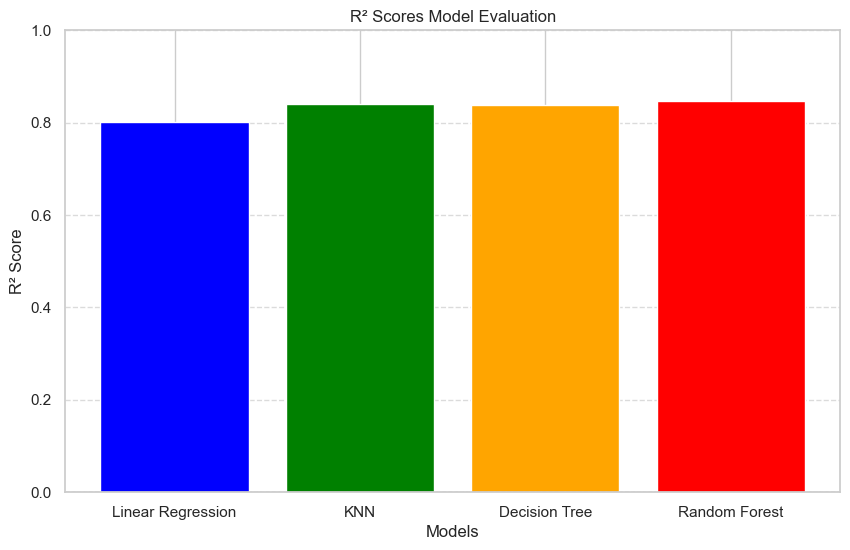

In [83]:
models = ['Linear Regression', 'KNN', 'Decision Tree', 'Random Forest']
r2_scores = [linear_regression_score, knn_score, decisiontree_score, randomforest_score]

plt.figure(figsize=(10, 6))
plt.bar(models, r2_scores, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)
plt.title('R² Scores Model Evaluation')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

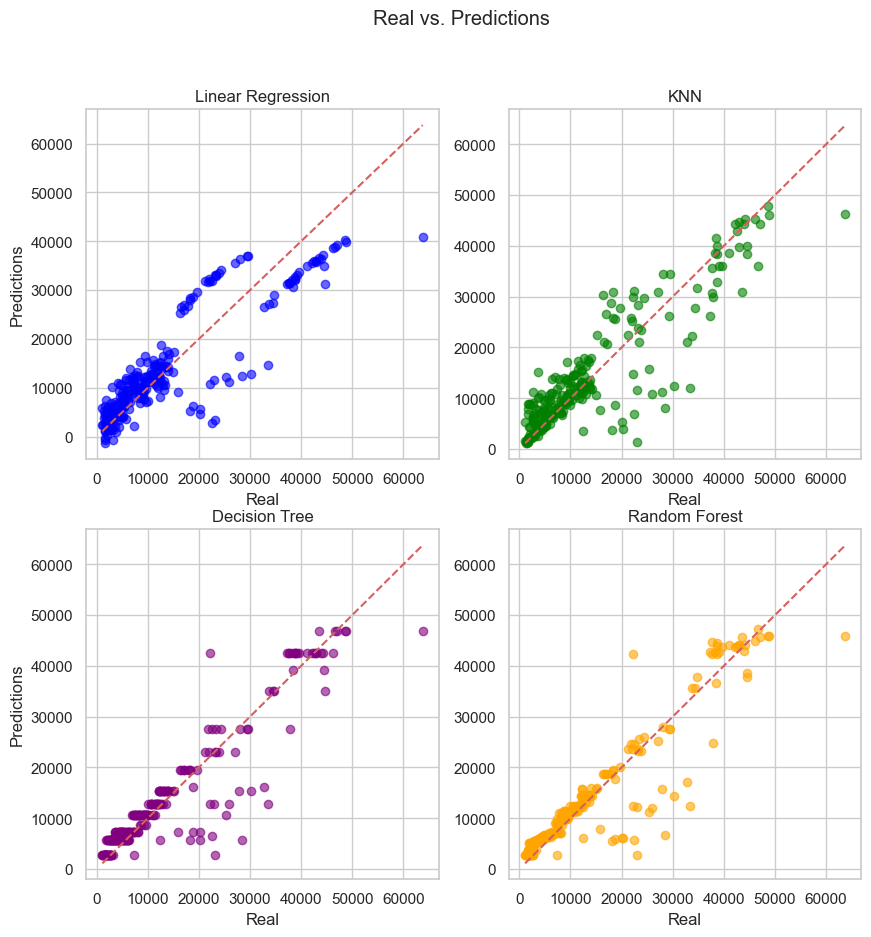

In [124]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].scatter(y_test, linear_regression_prediction, alpha=0.6, color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 0].set_title('Linear Regression')
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predictions')

axes[0, 1].scatter(y_test, knn_prediction, alpha=0.6, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 1].set_title('KNN')
axes[0, 1].set_xlabel('Real')

axes[1, 0].scatter(y_test, decisiontree_prediction, alpha=0.6, color='purple')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1, 0].set_title('Decision Tree')
axes[1, 0].set_xlabel('Real')
axes[1, 0].set_ylabel('Predictions')

axes[1, 1].scatter(y_test, randomforest_prediction, alpha=0.6, color='orange')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1, 1].set_title('Random Forest')
axes[1, 1].set_xlabel('Real')

plt.suptitle('Real vs. Predictions')
plt.show()


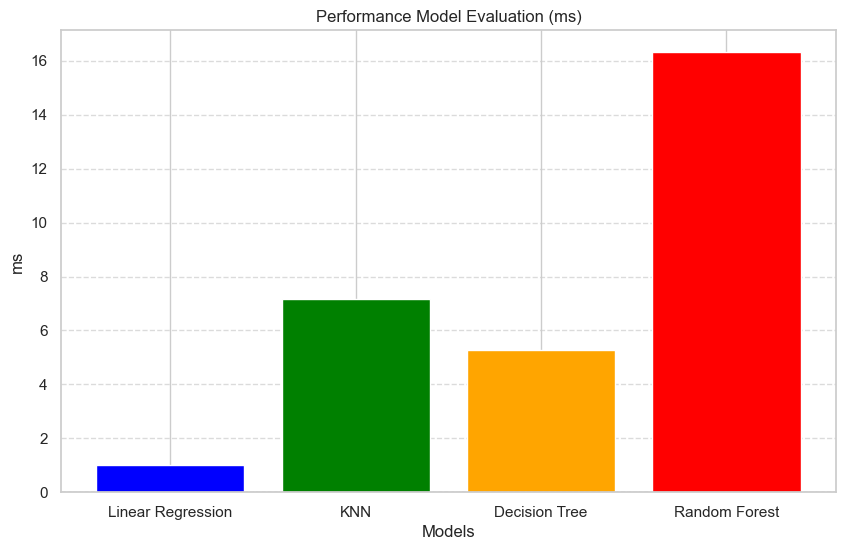

In [153]:
models = ['Linear Regression', 'KNN', 'Decision Tree', 'Random Forest']
r2_scores = [linear_predict_time, knn_predict_time, decision_tree_predict_time, random_forest_predict_time]

plt.figure(figsize=(10, 6))
plt.bar(models, r2_scores, color=['blue', 'green', 'orange', 'red'])
plt.title('Performance Model Evaluation (ms)')
plt.xlabel('Models')
plt.ylabel('ms')
plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Conslusão
Os resultados obtidos mostram que o Random Forest Regressor teve o melhor desempenho. O R² score e o gráfico de dispersão comparando com os dados reais mostram isso. Por outro lado, o custo computacional da regressão linear compesa bastante visto que o erro não está muito discrepante. O melhor custo benefício fica para a árvore de decisão que equilibra performance e acerto.